Periodic Boundary Problem
=========================
Here we want to solve a problem with a periodic boundary condition. We consider:
\begin{align*}
    - \Delta u(x, y) &= f(x, y), \text{ for } (x, y) \in [0, 1] \times  [0, 1]\\
    u(0, y) &= u(1, y)  , \text{ for } y \in [0, 1] \\
    u(x, y) &= 0 , \text{ for } x \in [0, 1], y \in \{0, 1\} \\
\end{align*}

In [1]:
import torch
import os
import pytorch_lightning as pl
import torchphysics as tp
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

In [2]:
# For the periodich condition we need to split up the domain in each direction:
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
P = tp.spaces.R1('u')

# Therefore we create here the interval and a square.
# Mathematically: square = X_domain * Y_domain 
# The square can be used inside the pde-condition and for plotting, to make 
# the sampling a little bit faster.
L = 1.0
X_domain = tp.domains.Interval(X, 0, L)
Y_domain = tp.domains.Interval(Y, 0, L)
square = tp.domains.Parallelogram(X*Y, [0, 0], [L, 0], [0, L])

In [3]:
model = tp.models.FCN(input_space=X*Y, output_space=P, hidden=(50, 50))

For a periodic boundary condition, there exists a special class: `tp.conditions.PeriodicCondition`.

In [4]:
# We only need to create a sampler for the y-variable, the condition will create the points
# in the x domain internally.
boundary_sampler = tp.samplers.RandomUniformSampler(Y_domain, n_points=3000)
# The condition will evaluate the model on the left and right boundary, for each input
# that is created with the `boundary_sampler`. The outputs can be used with 
# "'model_name'_left" and "'model_name'_right", here 'model_name' = u.
def bc_fun(u_left, u_right):
    return u_left - u_right

bound_cond = tp.conditions.PeriodicCondition(module=model,
                                             periodic_interval=X_domain,
                                             non_periodic_sampler=boundary_sampler,
                                             residual_fn=bc_fun, 
                                             weight=50.0)

The PDE and Dirchlet-Condition are like always:

In [5]:
dirichlet_sampler = tp.samplers.RandomUniformSampler(X_domain*Y_domain.boundary, n_points=3000)

def dirichlet_fun(u):
    return u

dirichlet_cond = tp.conditions.PINNCondition(model, dirichlet_sampler, dirichlet_fun)

In [6]:
def pde(u, x, y):
    u_xx = tp.utils.laplacian(u, x, y)
    f = 3*x*torch.sin(2*np.pi*y) + torch.exp(-((x-0.5)**2 + (y-0.5)**2)/0.05)
    return u_xx + f

pde_sampler = tp.samplers.RandomUniformSampler(square, n_points=8000)

pde_cond = tp.conditions.PINNCondition(module=model,
                                       sampler=pde_sampler, 
                                       residual_fn=pde)

In [7]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_cond, bound_cond, dirichlet_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.8 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 10, 'history_size': 100})

solver = tp.solver.Solver([pde_cond, bound_cond, dirichlet_cond], optimizer_setting=optim)
bound_cond.non_periodic_sampler = bound_cond.non_periodic_sampler.make_static()
pde_cond.sampler = pde_cond.sampler.make_static()
dirichlet_cond.sampler = dirichlet_cond.sampler.make_static()

trainer = pl.Trainer(gpus=1,
                     max_steps=1000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.8 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

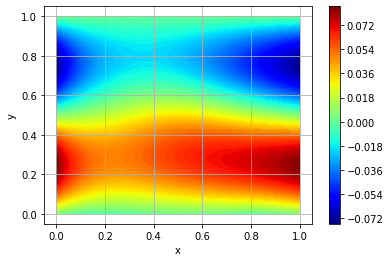

In [11]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=1000, device='cuda')
fig = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface')